
# <b><span style='color:#F1C40F'>|</span> 如何利用Gensim做词嵌入学习并作为Keras层的初始值</b>
本章内容来自于（小幅更改）:

-  📌 [Guide to word vectors with gensim and keras](https://www.depends-on-the-definition.com/guide-to-word-vectors-with-gensim-and-keras/)


In [ ]:
import gensim
import tensorflow
gensim.__version__
tensorflow.__version__

<b></b>
<div style="color:white;display:fill;border-radius:8px;
            background-color:#323232;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b>载入数据</b></p>
</div>

本教程用到的数据是一个Kaggle上的评论分类比赛。做的是将评论打上六种不同的“毒性”标签（toxic(恶意),severetoxic(穷凶极恶),obscene(猥琐),threat(恐吓),insult(侮辱),identityhate(种族歧视)）。这是一个多标签任务，即标签取值之间不是互斥的。


In [1]:
import pandas as pd

train_df = pd.read_csv( './data/txclas/train.csv')
test_df = pd.read_csv('./data/txclas/test.csv')

train_df.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


<div style="color:white;display:fill;border-radius:8px;
            background-color:#323232;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b>对文本数据进行预处理</b></p>
</div>

主要是由于原始数据里有大量的URL和IP地址。我们通过正则式的方式将所有的URL和IP地址对应的字符串替代成“URL”和“IPADDRESS”两个固定的字符串。并且在这个过程中，我们也同时做分词以及把字典维护起来。

In [2]:
print('Processing text dataset')
from nltk.tokenize import WordPunctTokenizer
from collections import Counter
from string import punctuation, ascii_lowercase
import regex as re
from tqdm import tqdm

# replace urls
re_url = re.compile(r"((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\
                    .([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*",
                    re.MULTILINE|re.UNICODE)
# replace ips
re_ip = re.compile("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}")

# setup tokenizer
tokenizer = WordPunctTokenizer()

vocab = Counter()

def text_to_wordlist(text, lower=False):
    # replace URLs
    text = re_url.sub("URL", text)
    
    # replace IPs
    text = re_ip.sub("IPADDRESS", text)
    
    # Tokenize
    text = tokenizer.tokenize(text)
    
    # optional: lower case
    if lower:
        text = [t.lower() for t in text]
    
    # Return a list of words
    vocab.update(text)
    return text

def process_comments(list_sentences, lower=False):
    comments = []
    for text in tqdm(list_sentences):
        txt = text_to_wordlist(text, lower=lower)
        comments.append(txt)
    return comments


list_sentences_train = list(train_df["comment_text"].fillna("NAN_WORD").values)
list_sentences_test = list(test_df["comment_text"].fillna("NAN_WORD").values)

comments = process_comments(list_sentences_train + list_sentences_test, lower=True)

Processing text dataset


100%|███████████████████████████████████████████████████████████████████████| 312735/312735 [00:18<00:00, 17239.60it/s]


In [3]:
print("The vocabulary contains {} unique tokens".format(len(vocab)))

The vocabulary contains 365516 unique tokens


In [4]:
comments[0]

['explanation',
 'why',
 'the',
 'edits',
 'made',
 'under',
 'my',
 'username',
 'hardcore',
 'metallica',
 'fan',
 'were',
 'reverted',
 '?',
 'they',
 'weren',
 "'",
 't',
 'vandalisms',
 ',',
 'just',
 'closure',
 'on',
 'some',
 'gas',
 'after',
 'i',
 'voted',
 'at',
 'new',
 'york',
 'dolls',
 'fac',
 '.',
 'and',
 'please',
 'don',
 "'",
 't',
 'remove',
 'the',
 'template',
 'from',
 'the',
 'talk',
 'page',
 'since',
 'i',
 "'",
 'm',
 'retired',
 'now',
 '.',
 'ipaddress']

<div style="color:white;display:fill;border-radius:8px;
            background-color:#323232;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b>通过Gensim学习词嵌入/词向量</b></p>
</div>

当句子已经被表达成为了词序列之后，我们便可以通过gensim工具包中的词嵌入工具来通过语料学习词嵌入矩阵，即学习到一个词->向量的映射。
在这里，我们选用CBOW算法，并设定我们要学习到低维词向量的维度为100维。

具体地，可以参考[Gensim的Word2Vec工具](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec)


In [6]:
model_cbow = Word2Vec(comments, vector_size =100, window=5, min_count=5, workers=16, sg=0, negative=5) # if sg=1, we use Skip-gram

我们将会发现被编码的词的数量和原始字典里词的数量不一致是因为Word2Vec的参数里，我们设定了min_count=5，即它会忽略掉那些出现频率小于5的词。

在这里，我们用经典的king-man+woman的示例来展示学到的词向量的效果

In [7]:
print("Number of word vectors: {}".format(len(model_cbow.wv.key_to_index )))
model_cbow.wv.most_similar_cosmul(positive=['woman', 'king'], negative=['man'])

Number of word vectors: 70056


[('princess', 0.9699100255966187),
 ('prince', 0.9637281894683838),
 ('queen', 0.9552358388900757),
 ('mary', 0.9286278486251831),
 ('bishop', 0.9226716160774231),
 ('duchess', 0.9200853109359741),
 ('surname', 0.9097630381584167),
 ('descendant', 0.9067777395248413),
 ('shah', 0.9065886735916138),
 ('pope', 0.9054287075996399)]

<div style="color:white;display:fill;border-radius:8px;
            background-color:#323232;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b>对数据进行截断或填补处理</b></p>
</div>

由于原始的句子所包含的词数是不一样的。但RNN是接受定长的序列数据作为输入。所以我们需要在这里设定一个句子长度的值。并对之前的序列数据做cut或pad处理。

In [9]:
MAX_NB_WORDS = len(model_cbow.wv.key_to_index)
MAX_SEQUENCE_LENGTH = 200

from tensorflow.keras.preprocessing.sequence import pad_sequences

word_index = {t[0]: i+1 for i,t in enumerate(vocab.most_common(MAX_NB_WORDS))}
sequences = [[word_index.get(t, 0) for t in comment]
             for comment in comments[:len(list_sentences_train)]]
test_sequences = [[word_index.get(t, 0)  for t in comment] 
                  for comment in comments[len(list_sentences_train):]]

# pad
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, 
                     padding="pre", truncating="post")
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train_df[list_classes].values
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y.shape)

test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="pre",
                          truncating="post")
print('Shape of test_data tensor:', test_data.shape)

Shape of data tensor: (159571, 200)
Shape of label tensor: (159571, 6)
Shape of test_data tensor: (153164, 200)


<div style="color:white;display:fill;border-radius:8px;
            background-color:#323232;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b>构造嵌入层的初始化矩阵参数</b></p>
</div>

下来我们构造一个可以作为后续嵌入层参数的矩阵：

In [31]:
import numpy as np
WV_DIM = 100
nb_words = min(MAX_NB_WORDS, len(model_cbow.wv.key_to_index))
# 我们首先先随机初始化嵌入矩阵
wv_matrix = (np.random.rand(nb_words, WV_DIM) - 0.5) / 5.0
# 然后尝试地将已经学习好的词向量覆盖掉矩阵的对应元素
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    try :
        embedding_vector = model_cbow.wv.get_vector(word)
        wv_matrix[i] = embedding_vector
    except:
        print('can not find word', word)
        pass     

<div style="color:white;display:fill;border-radius:8px;
            background-color:#323232;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b>定义并训练网络</b></p>
</div>

在定义网络的时候，我们将嵌入层定义成是用我们刚刚得到的矩阵作为初始参数的一个嵌入层

In [32]:

from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout,SpatialDropout1D, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization

wv_layer = Embedding(nb_words,
                     WV_DIM,
                     mask_zero=False,
                     weights=[wv_matrix], # 在这里，我们用之前构建的wv_matrix作为初始参数的设定
                     input_length=MAX_SEQUENCE_LENGTH,
                     trainable=False)

# Inputs
comment_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = wv_layer(comment_input)

# biLSTM
embedded_sequences = SpatialDropout1D(0.2)(embedded_sequences)
x = Bidirectional(LSTM(64, return_sequences=False))(embedded_sequences)

# Output
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
preds = Dense(6, activation='sigmoid')(x)

# build the model
model = Model(inputs=[comment_input], outputs=preds)
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.001, clipnorm=.25, beta_1=0.7, beta_2=0.99),
              metrics=[])
              
hist = model.fit([data], y, validation_split=0.1, epochs=10, batch_size=256, shuffle=True)

Epoch 1/10
561/561 [==============================] - 1104s 2s/step - loss: 0.1752 - val_loss: 0.0544
Epoch 2/10
561/561 [==============================] - 1168s 2s/step - loss: 0.0570 - val_loss: 0.0505
Epoch 3/10
561/561 [==============================] - 1171s 2s/step - loss: 0.0527 - val_loss: 0.0482
Epoch 4/10
561/561 [==============================] - 1211s 2s/step - loss: 0.0498 - val_loss: 0.0468
Epoch 5/10
561/561 [==============================] - 1176s 2s/step - loss: 0.0475 - val_loss: 0.0456
Epoch 6/10
561/561 [==============================] - 1127s 2s/step - loss: 0.0462 - val_loss: 0.0452
Epoch 7/10
561/561 [==============================] - 1181s 2s/step - loss: 0.0450 - val_loss: 0.0446
Epoch 8/10
561/561 [==============================] - 1183s 2s/step - loss: 0.0449 - val_loss: 0.0441
Epoch 9/10
561/561 [==============================] - 1173s 2s/step - loss: 0.0439 - val_loss: 0.0442
Epoch 10/10
561/561 [==============================] - 1225s 2s/step - loss: 0.042

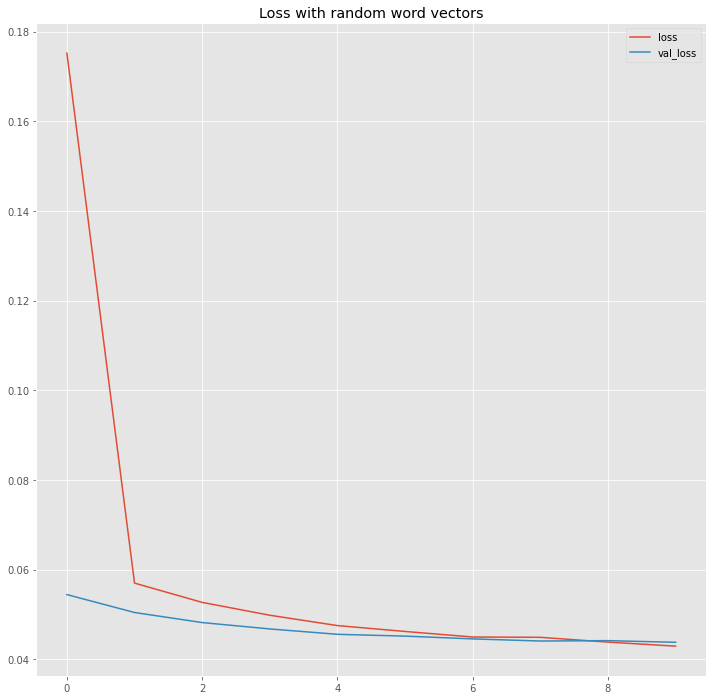

In [37]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
history = pd.DataFrame(hist.history)
plt.figure(figsize=(12,12))
plt.plot(history["loss"], label='loss')
plt.plot(history["val_loss"], label='val_loss')
plt.title("Loss with random word vectors")
plt.legend()
plt.show()

<div style="color:white;display:fill;border-radius:8px;
            background-color:#323232;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b>对比</b></p>
</div>

接下来，我们定义一个相同结构的网络，只是嵌入层的参数我们不再做初始值的设定

In [18]:
wv_layer = Embedding(nb_words,
                     WV_DIM,
                     mask_zero=False,
                     # weights=[wv_matrix],
                     input_length=MAX_SEQUENCE_LENGTH,
                     trainable=False)

# Inputs
comment_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = wv_layer(comment_input)

# biLSTM
embedded_sequences = SpatialDropout1D(0.2)(embedded_sequences)
x = Bidirectional(LSTM(64, return_sequences=False))(embedded_sequences)

# Output
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
preds = Dense(6, activation='sigmoid')(x)

# build the model
model = Model(inputs=[comment_input], outputs=preds)
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.001, clipnorm=.25, beta_1=0.7, beta_2=0.99),
              metrics=[])

hist_ = model.fit([data], y, validation_split=0.1,
                 epochs=10, batch_size=256, shuffle=True)

Epoch 1/10
561/561 [==============================] - 717s 1s/step - loss: 0.1793 - val_loss: 0.1265
Epoch 2/10
561/561 [==============================] - 695s 1s/step - loss: 0.1074 - val_loss: 0.1163
Epoch 3/10
561/561 [==============================] - 714s 1s/step - loss: 0.1037 - val_loss: 0.1042
Epoch 4/10
561/561 [==============================] - 724s 1s/step - loss: 0.0989 - val_loss: 0.0959
Epoch 5/10
561/561 [==============================] - 710s 1s/step - loss: 0.0936 - val_loss: 0.1202
Epoch 6/10
561/561 [==============================] - 715s 1s/step - loss: 0.0888 - val_loss: 0.0863
Epoch 7/10
561/561 [==============================] - 719s 1s/step - loss: 0.0863 - val_loss: 0.0856
Epoch 8/10
561/561 [==============================] - 724s 1s/step - loss: 0.0837 - val_loss: 0.0886
Epoch 9/10
561/561 [==============================] - 727s 1s/step - loss: 0.0811 - val_loss: 0.0806
Epoch 10/10
561/561 [==============================] - 739s 1s/step - loss: 0.0791 - val_lo

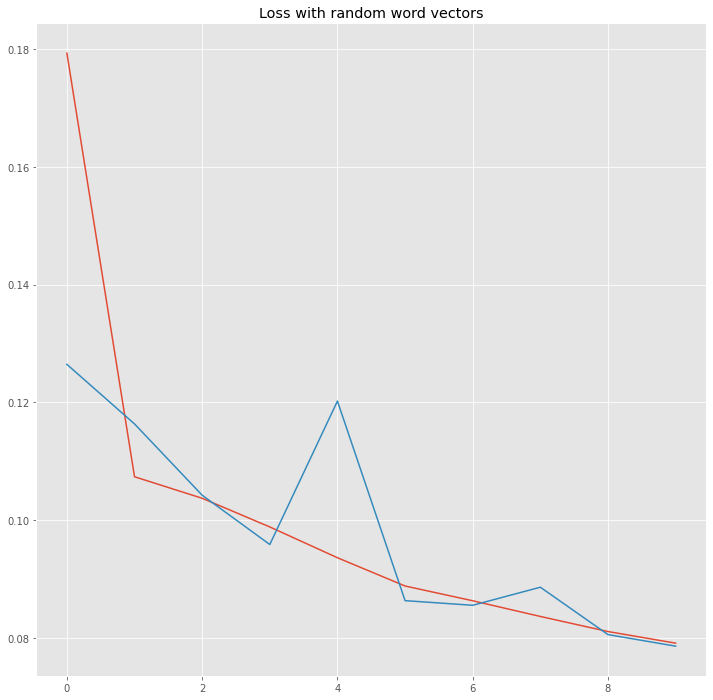

In [19]:
history = pd.DataFrame(hist_.history)
plt.figure(figsize=(12,12));
plt.plot(history["loss"]);
plt.plot(history["val_loss"]);
plt.title("Loss with random word vectors");
plt.show();